In [54]:

import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.feature_selection import VarianceThreshold
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from numpy import isnan
# Statistics functions
from scipy.stats import norm
from scipy import stats
from scipy.stats import chi2_contingency
from scipy.stats import chi2


In [55]:
!pip install boto3
import psycopg2
import sys
import boto3
import os


ENDPOINT="houseprices11.cbchqixwjhxz.us-east-2.rds.amazonaws.com"
PORT="5432"
USER="postgres"
REGION="us-east-2"
DBNAME="houseprices"

#gets the credentials from .aws/credentials
# session = boto3.Session(profile_name='RDSCreds')
# client = session.client('rds')
# token = client.generate_db_auth_token(DBHostname=ENDPOINT, Port=PORT, DBUsername=USER, Region=REGION)

try:
     conn = psycopg2.connect(host=ENDPOINT, port=PORT, database=DBNAME, user=USER, password='finaldal', sslrootcert="SSLCERTIFICATE")
     cur = conn.cursor()
     cur.execute("""SELECT now()""")
     query_results = cur.fetchall()
     print(query_results)
except Exception as e:
     print("Database connection failed due to {}".format(e))        

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
[(datetime.datetime(2022, 7, 6, 23, 48, 17, 152575, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),)]


## Extracting and Exploring the data

In [56]:
cur = conn.cursor()
cur.execute("""SELECT now()""")
query_results = cur.fetchall()
print(query_results)
      

[(datetime.datetime(2022, 7, 6, 23, 48, 17, 152575, tzinfo=psycopg2.tz.FixedOffsetTimezone(offset=0, name=None)),)]


In [57]:
cur.execute("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
for table in cur.fetchall():
    print(table)

('houses',)
('prices',)
('joined_data',)


In [58]:
import pandas.io.sql as sqlio
sql = "select * from joined_data ;"
df_data = sqlio.read_sql_query(sql, conn)
df_data.head(10)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000
5,6,50,RL,85,14115,Pave,NA,IR1,Lvl,AllPub,...,0,NA,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75,10084,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,8,2007,WD,Normal,307000
7,8,60,RL,NA,10382,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51,6120,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50,7420,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,1,2008,WD,Normal,118000


Let's find out the columns which have more than 30% NA, and drop them. And let's drop the column 'Id'.

In [59]:

nb_row=df_data.shape[0]
for col in df_data.columns:
  cnt=0
  for i in range(nb_row):
     if df_data[col][i]=='NA':
      cnt=cnt+1    
  if cnt/nb_row>0.3:
      df_data.drop(col, axis =1 , inplace=True) 
df_data.drop('Id', axis =1 , inplace=True)
df_data.head(10)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,2,2008,WD,Normal,208500
1,20,RL,80,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,5,2007,WD,Normal,181500
2,60,RL,68,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,9,2008,WD,Normal,223500
3,70,RL,60,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,272,0,0,0,0,2,2006,WD,Abnorml,140000
4,60,RL,84,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,0,0,0,0,0,12,2008,WD,Normal,250000
5,50,RL,85,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,320,0,0,700,10,2009,WD,Normal,143000
6,20,RL,75,10084,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,0,0,0,0,8,2007,WD,Normal,307000
7,60,RL,NA,10382,Pave,IR1,Lvl,AllPub,Corner,Gtl,...,228,0,0,0,350,11,2009,WD,Normal,200000
8,50,RM,51,6120,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,205,0,0,0,0,4,2008,WD,Abnorml,129900
9,190,RL,50,7420,Pave,Reg,Lvl,AllPub,Corner,Gtl,...,0,0,0,0,0,1,2008,WD,Normal,118000


### Exploring and Cleaning Numerical features


In [60]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MSSubClass     1460 non-null   int64 
 1   MSZoning       1460 non-null   object
 2   LotFrontage    1460 non-null   object
 3   LotArea        1460 non-null   int64 
 4   Street         1460 non-null   object
 5   LotShape       1460 non-null   object
 6   LandContour    1460 non-null   object
 7   Utilities      1460 non-null   object
 8   LotConfig      1460 non-null   object
 9   LandSlope      1460 non-null   object
 10  Neighborhood   1460 non-null   object
 11  Condition1     1460 non-null   object
 12  Condition2     1460 non-null   object
 13  BldgType       1460 non-null   object
 14  HouseStyle     1460 non-null   object
 15  OverallQual    1460 non-null   int64 
 16  OverallCond    1460 non-null   int64 
 17  YearBuilt      1460 non-null   int64 
 18  YearRemodAdd   1460 non-null

There are some columns which are numerical although they are object type in the dataframe. They are 'LotFrontage','LotArea','MasVnrArea' and 'GarageYrBlt'. Before starting to work on numerical features, let's change their datatype first.

In [61]:
change_datatype=['LotFrontage','LotArea','MasVnrArea','GarageYrBlt']
for i in range(len(change_datatype)):
   df_data[change_datatype[i]] = pd.to_numeric(df_data[change_datatype[i]],errors='coerce')
df_data[change_datatype].info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   LotFrontage  1201 non-null   float64
 1   LotArea      1460 non-null   int64  
 2   MasVnrArea   1452 non-null   float64
 3   GarageYrBlt  1379 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 45.8 KB


In [62]:
df_data_num=df_data.select_dtypes(include=[np.number])
df_data_num.head()

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,60,65.00,8450,7,5,2003,2003,196.00,706,0,...,0,61,0,0,0,0,0,2,2008,208500
1,20,80.00,9600,6,8,1976,1976,0.00,978,0,...,298,0,0,0,0,0,0,5,2007,181500
2,60,68.00,11250,7,5,2001,2002,162.00,486,0,...,0,42,0,0,0,0,0,9,2008,223500
3,70,60.00,9550,7,5,1915,1970,0.00,216,0,...,0,35,272,0,0,0,0,2,2006,140000
4,60,84.00,14260,8,5,2000,2000,350.00,655,0,...,192,84,0,0,0,0,0,12,2008,250000


#### Dropping quisi-constant features in which 95% of the values are same or similar.

In [63]:
# 0.05: drop column where 95% of the values are constant
sel = VarianceThreshold(threshold=0.05) 

# fit finds the features with constant variance
sel.fit(df_data_num.iloc[:, :-1])


# Get the number of features that are not constant
print(f"Number of retained features: {sum(sel.get_support())}")

print(f"\nNumber of quasi_constant features: {len(df_data_num.iloc[:, :-1].columns) - sum(sel.get_support())}")

quasi_constant_features_list = [x for x in df_data_num.iloc[:, :-1].columns if x not in df_data_num.iloc[:, :-1].columns[sel.get_support()]]

print(f"\nQuasi-constant features to be dropped: {quasi_constant_features_list}")

# Let's drop these columns from the data frame
df_data_num.drop(quasi_constant_features_list, axis=1, inplace=True)


Number of retained features: 35

Number of quasi_constant features: 1

Quasi-constant features to be dropped: ['KitchenAbvGr']


#### Determining Strongly correlated features and dropping them


 Correlation coefficient which is more than 0.8 suggests a strong relationship between the features, so we can drop one of the features. For this reason, we are going to look at correlation ciefficient matrix. 

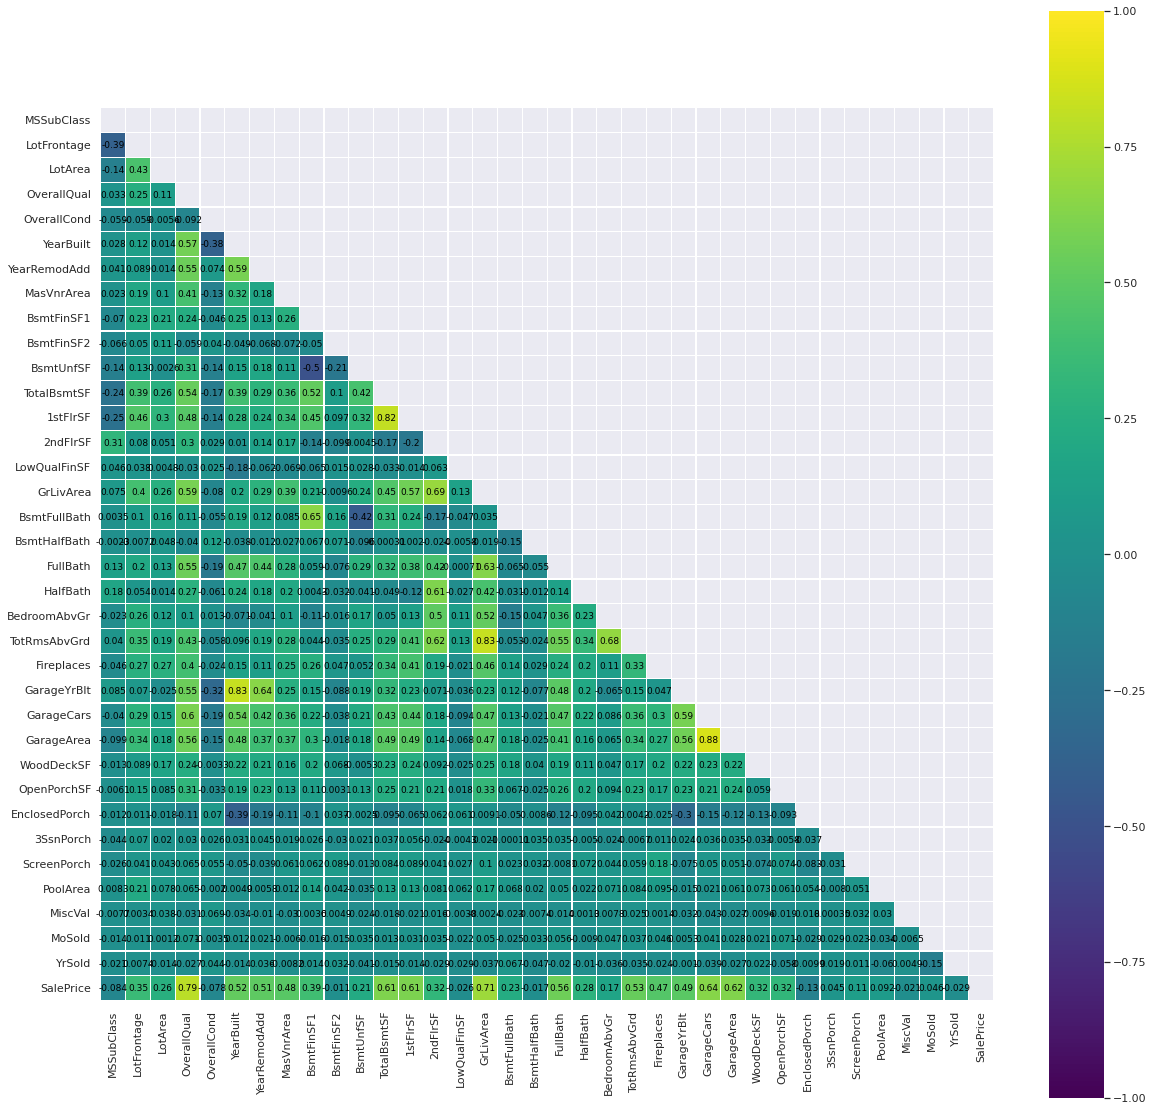

In [64]:
fig = plt.figure(figsize=(20,20))
# Define the heatmap parameters
pd.options.display.float_format = "{:,.2f}".format

# Define correlation matrix 
# (method = pearson: standard correlation coefficient)
corr_matrix = df_data_num.corr(method = 'pearson')

# Mask the upper part of the heatmap
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Choose the color map
cmap = "viridis"

# plot the heatmap
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap=cmap, annot=True)

According to the correlation coefficient matrix the following features have strong relation pairwisely:

"GarageArea" and "GarageCars" (0.88)


"GarageYrBlt" and "YearBuilt" (0.83)

"TotRmsAbvGrd" and "GrLivArea" (0.83)

"1stFlrSF" and "TotalBsmtSF"(0.82)

So we can drop one of the features in a a strtongly correlated pairs.

In [65]:
# Strongly Correlated Features
strong_feat = ["GarageArea", "GarageYrBlt" ,"1stFlrSF", "TotRmsAbvGrd"]
# Drop strongly corelated Features from both dataframes.
df_data_num.drop(strong_feat, axis =1 , inplace=True)

#### Determining and Dropping features which have very weak correlation with 'SalePrice'.

If the correlation coefficient between a feature and 'SalesPrice' 0.3 then we accept it as weak feature and drop it.

In [66]:
df_num_corr = df_data_num.corr()["SalePrice"][:-1]

weak_features_list = df_num_corr[abs(df_num_corr) < 0.3].sort_values(ascending=False)
print(f"{len(weak_features_list)} weakly correlated values with SalePrice:\n{weak_features_list}\n")

weak_features = df_num_corr[abs(df_num_corr) < 0.3].index.tolist()

17 weakly correlated values with SalePrice:
HalfBath         0.28
LotArea          0.26
BsmtFullBath     0.23
BsmtUnfSF        0.21
BedroomAbvGr     0.17
ScreenPorch      0.11
PoolArea         0.09
MoSold           0.05
3SsnPorch        0.04
BsmtFinSF2      -0.01
BsmtHalfBath    -0.02
MiscVal         -0.02
LowQualFinSF    -0.03
YrSold          -0.03
OverallCond     -0.08
MSSubClass      -0.08
EnclosedPorch   -0.13
Name: SalePrice, dtype: float64



In [67]:
# Remove 17 variables weakly correlated with SalePrice from the data
df_data_num.drop(weak_features,axis=1, inplace=True)

#### Missing Data Inputation of Numerical Features

In [68]:
df_data_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1201 non-null   float64
 1   OverallQual   1460 non-null   int64  
 2   YearBuilt     1460 non-null   int64  
 3   YearRemodAdd  1460 non-null   int64  
 4   MasVnrArea    1452 non-null   float64
 5   BsmtFinSF1    1460 non-null   int64  
 6   TotalBsmtSF   1460 non-null   int64  
 7   2ndFlrSF      1460 non-null   int64  
 8   GrLivArea     1460 non-null   int64  
 9   FullBath      1460 non-null   int64  
 10  Fireplaces    1460 non-null   int64  
 11  GarageCars    1460 non-null   int64  
 12  WoodDeckSF    1460 non-null   int64  
 13  OpenPorchSF   1460 non-null   int64  
 14  SalePrice     1460 non-null   int64  
dtypes: float64(2), int64(13)
memory usage: 171.2 KB


As we see in the above info, there are two features which have missing values to be fillied, they are 'LotFrontage' and 'MasVnrArea ' . 

We are going to use three inputation methods to fill and compare them by using shapes of the distributions before and after filling.

The imputation merthods are SimpleImputer(strategy="median"),SimpleImputer(strategy="most_frequent") and KNNInputer.

##### SimpleImputer(strategy="median")

In [69]:
# Imputation of missing values with SimpleImputer
my_imputer = SimpleImputer(strategy="median")
df_data_imputed_median = pd.DataFrame(my_imputer.fit_transform(df_data_num))
df_data_imputed_median.columns = df_data_num.columns

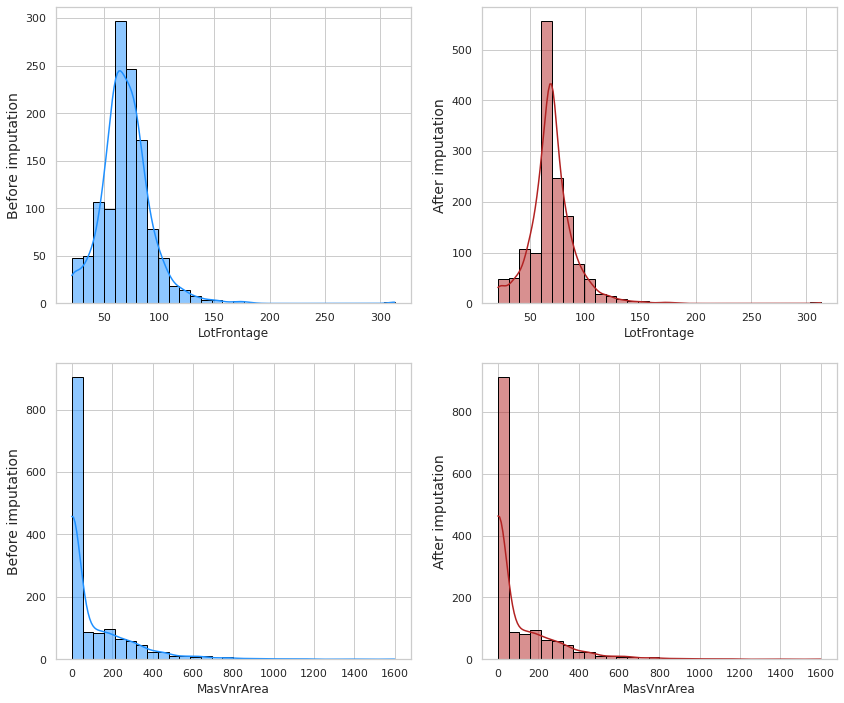

In [70]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_data_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_data_imputed_median[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

It looks this method creates a big change in the shape of 'LotFrontage' feature before and after inputing.

##### SimpleImputer(strategy="most_frequent")

In [71]:
# Imputation of missing values with SimpleImputer
my_imputer = SimpleImputer(strategy="most_frequent")
df_data_imputed_mode = pd.DataFrame(my_imputer.fit_transform(df_data_num))
df_data_imputed_mode.columns = df_data_num.columns

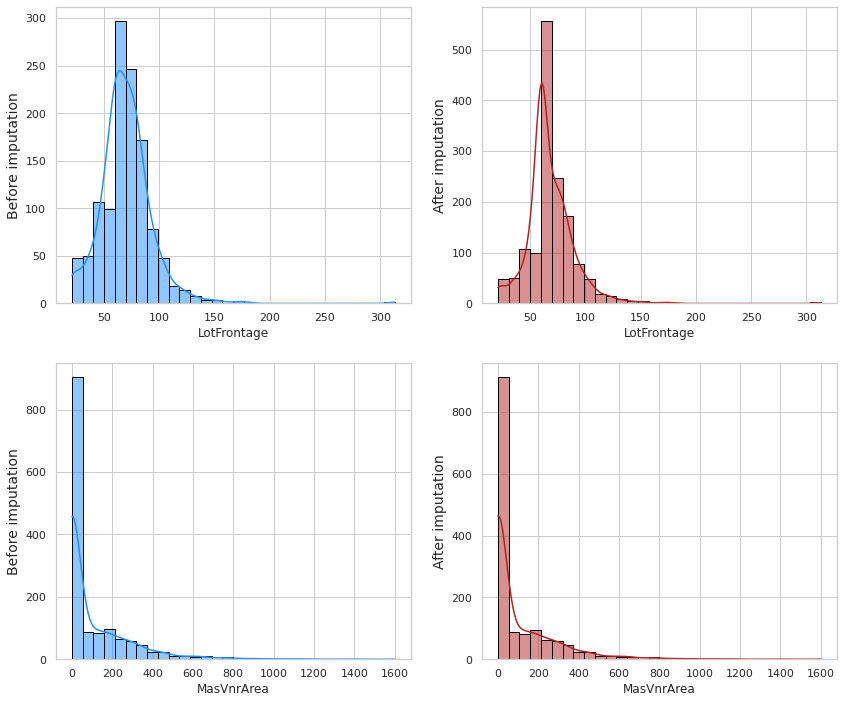

In [72]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_data_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_data_imputed_mode[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

It looks this method also creates a big change in the shape of 'LotFrontage' feature before and after inputing.

##### KNNImputer

In [73]:
# define imputer
imputer = KNNImputer()
# fit on the dataset
imputer.fit(df_data_num)
# transform the dataset
Xtrans = imputer.transform(df_data_num)
df_data_imputed_KNN=pd.DataFrame(Xtrans, columns=df_data_num.columns).astype(df_data_num.dtypes.to_dict())

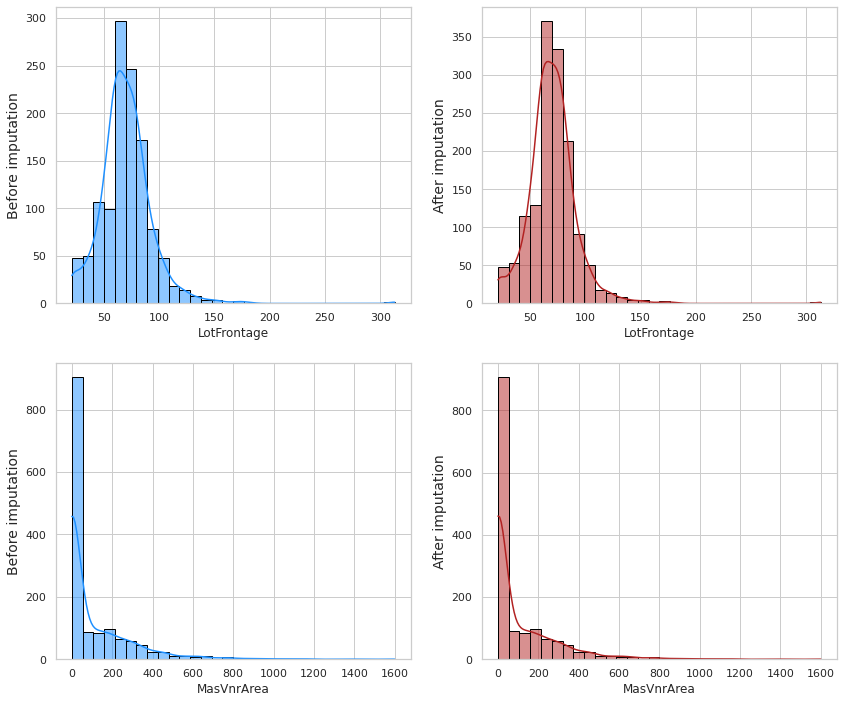

In [74]:
# Define figure parameters
sns.set(rc={"figure.figsize": (14, 12)})
sns.set_style("whitegrid")
fig, axes = plt.subplots(2, 2)

# Plot the results
for feature, fig_pos in zip(["LotFrontage", "MasVnrArea"], [0, 1]):

    """Features distribution before and after imputation"""

    # before imputation
    p = sns.histplot(ax=axes[fig_pos, 0], x=df_data_num[feature],
                     kde=True, bins=30, color="dodgerblue", edgecolor="black")
    p.set_ylabel(f"Before imputation", fontsize=14)

    # after imputation
    q = sns.histplot(ax=axes[fig_pos, 1], x=df_data_imputed_KNN[feature],
                     kde=True, bins=30, color="firebrick", edgecolor="black")
    q.set_ylabel(f"After imputation", fontsize=14)

This method  creates a small change in the shape of 'LotFrontage' feature before and after inputing. 

So the most relevant method looks KNNImputer.

So the cleaned numerical features will be as follows:

In [75]:
df_data_imputed_KNN.head(10)

,LotFrontage,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,TotalBsmtSF,2ndFlrSF,GrLivArea,FullBath,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,SalePrice
0,65.00,7,2003,2003,196.00,706,856,854,1710,2,0,2,0,61,208500
1,80.00,6,1976,1976,0.00,978,1262,0,1262,2,1,2,298,0,181500
2,68.00,7,2001,2002,162.00,486,920,866,1786,2,1,2,0,42,223500
3,60.00,7,1915,1970,0.00,216,756,756,1717,1,1,3,0,35,140000
4,84.00,8,2000,2000,350.00,655,1145,1053,2198,2,1,3,192,84,250000
5,85.00,5,1993,1995,0.00,732,796,566,1362,1,0,2,40,30,143000
6,75.00,8,2004,2005,186.00,1369,1686,0,1694,2,1,2,255,57,307000
7,77.80,7,1973,1973,240.00,859,1107,983,2090,2,2,2,235,204,200000
8,51.00,7,1931,1950,0.00,0,952,752,1774,2,2,2,90,0,129900
9,50.00,5,1939,1950,0.00,851,991,0,1077,1,2,1,0,4,118000


In [90]:
# Drop the salePrice column
df_data_imputed_KNN.drop('SalePrice',axis=1, inplace=True)
df_data_imputed_KNN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   LotFrontage   1460 non-null   float64
 1   OverallQual   1460 non-null   int64  
 2   YearBuilt     1460 non-null   int64  
 3   YearRemodAdd  1460 non-null   int64  
 4   MasVnrArea    1460 non-null   float64
 5   BsmtFinSF1    1460 non-null   int64  
 6   TotalBsmtSF   1460 non-null   int64  
 7   2ndFlrSF      1460 non-null   int64  
 8   GrLivArea     1460 non-null   int64  
 9   FullBath      1460 non-null   int64  
 10  Fireplaces    1460 non-null   int64  
 11  GarageCars    1460 non-null   int64  
 12  WoodDeckSF    1460 non-null   int64  
 13  OpenPorchSF   1460 non-null   int64  
dtypes: float64(2), int64(12)
memory usage: 159.8 KB


### Exploring and Cleaning Categorical features

In [77]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   LotShape       1460 non-null   object 
 6   LandContour    1460 non-null   object 
 7   Utilities      1460 non-null   object 
 8   LotConfig      1460 non-null   object 
 9   LandSlope      1460 non-null   object 
 10  Neighborhood   1460 non-null   object 
 11  Condition1     1460 non-null   object 
 12  Condition2     1460 non-null   object 
 13  BldgType       1460 non-null   object 
 14  HouseStyle     1460 non-null   object 
 15  OverallQual    1460 non-null   int64  
 16  OverallCond    1460 non-null   int64  
 17  YearBuilt      1460 non-null   int64  
 18  YearRemo

In [78]:
categorical_features = [i for i in df_data.columns if df_data.dtypes[i] == "object"]
categorical_features.append("SalePrice")

# Train set
df_data_categ = df_data[categorical_features]

# Test set (-1 because test set don't have 'Sale Price')

df_data_categ.columns

Index(['MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
       'PavedDrive', 'SaleType', 'SaleCondition', 'SalePrice'],
      dtype='object')

In [79]:
print(f"Training set shape (Categorical features): {df_data_categ.shape}\n")

Training set shape (Categorical features): (1460, 39)



In [80]:
df_data_categ

,MSZoning,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,...,KitchenQual,Functional,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,SaleType,SaleCondition,SalePrice
0,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,208500
1,RL,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,181500
2,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,223500
3,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Detchd,Unf,TA,TA,Y,WD,Abnorml,140000
4,RL,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,...,TA,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,175000
1456,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,Norm,...,TA,Min1,Attchd,Unf,TA,TA,Y,WD,Normal,210000
1457,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,Norm,...,Gd,Typ,Attchd,RFn,TA,TA,Y,WD,Normal,266500
1458,RL,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,Norm,...,Gd,Typ,Attchd,Unf,TA,TA,Y,WD,Normal,142125


There are 38 categorical features. As it is seen in the dataframe above some of them such as

'Street',    'LandContour','Utilities','LandSlope','Condition2',
'RoofMatl', 'BsmtCond','BsmtFinType2', 'Heating',  'CentralAir',
'Electrical','Functional', 'GarageQual','GarageCond', 'PavedDrive

have similar or the same values, so they do not create significant change in the price. 

We are going to drop these features.


In [81]:
cols_to_drop = [
    'Street',
    'LandContour',
    'Utilities',
    'LandSlope',
    'Condition2',
    'RoofMatl',
    'BsmtCond',
    'BsmtFinType2',
    'Heating',
    'CentralAir',
    'Electrical',
    'Functional',
    'GarageQual',
    'GarageCond',
    'PavedDrive'
]

# Drop these columns from dataset
df_data_categ.drop(cols_to_drop, axis=1, inplace=True)


In [82]:
print(f"Data set shape (Categorical features): {df_data_categ.shape}\n")

Data set shape (Categorical features): (1460, 24)



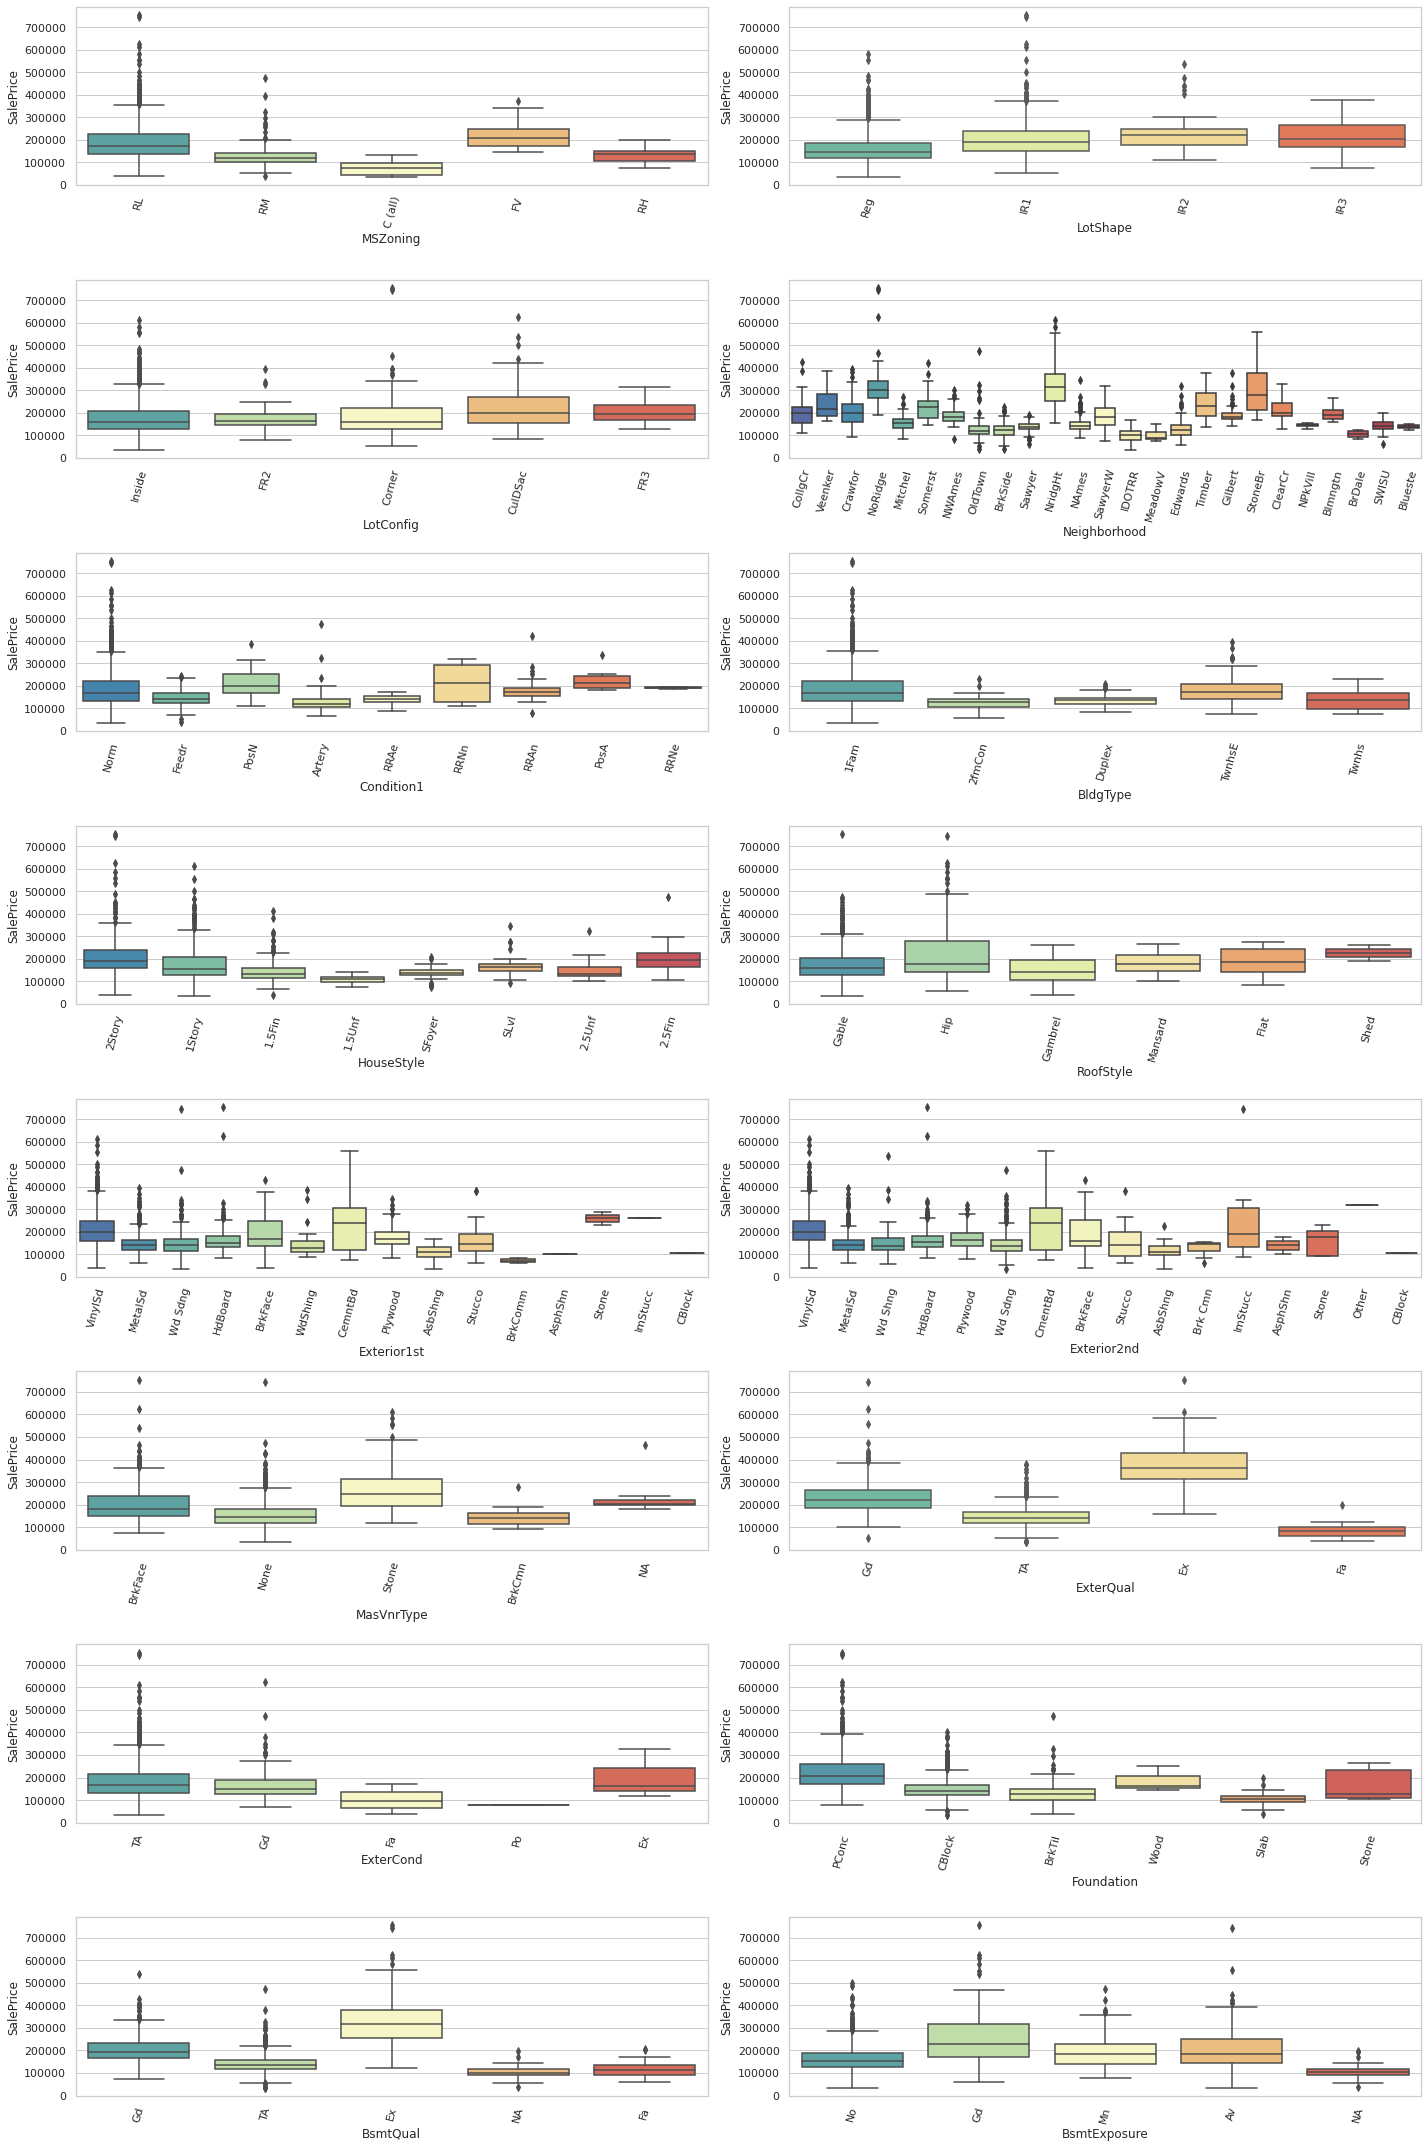

In [83]:
fig, axes = plt.subplots(
    round(len(df_data_categ.columns)/3), 2, figsize=(20, 30))

for i, ax in enumerate(fig.axes):
    # plot the variation of SalePrice in each feature
    if i < len(df_data_categ.columns) - 1:
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=75)
        sns.boxplot(x=df_data_categ.columns[i], y="SalePrice", data=df_data_categ, ax=ax, palette="Spectral_r")

fig.tight_layout()

If we look at closely the box plots above, we can see that there are three pairs of categorical variables for which the distribution of sale price is very similar, they are

"Exterior1st" and "Exterior2nd"

"ExterQual" and "MasVnrType"

"BsmtQual" and "BsmtExposure"

It looks they are dependent pairwisely. We are going to check if they are dependent or independent by using Chi-Square test.

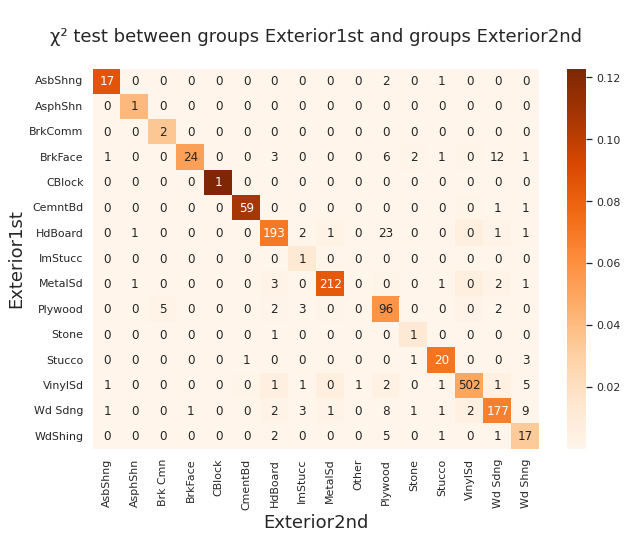

P-Value of the ChiSq Test bewteen Exterior1st and Exterior2nd is: 0.0



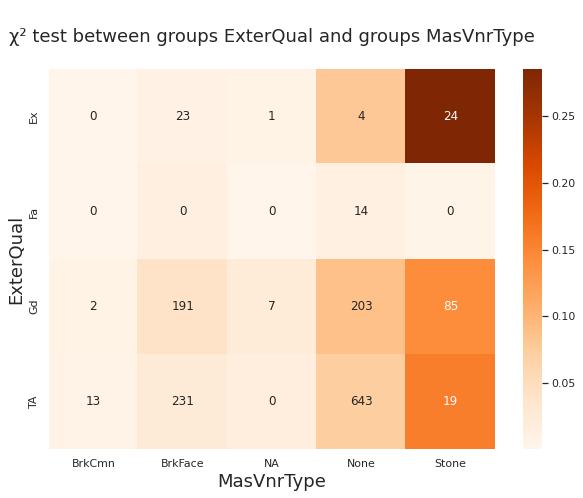

P-Value of the ChiSq Test bewteen ExterQual and MasVnrType is: 4.7495842936129416e-55



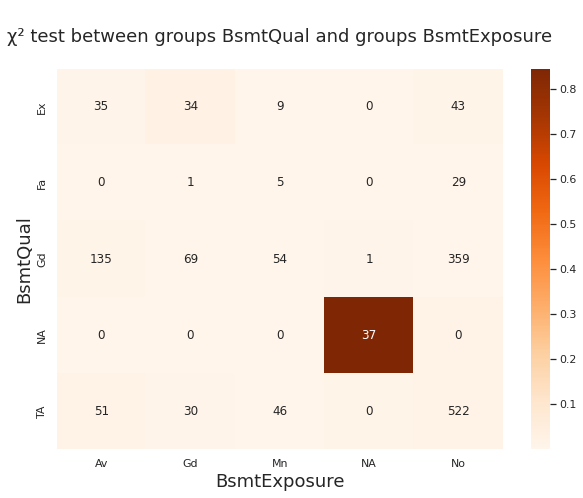

P-Value of the ChiSq Test bewteen BsmtQual and BsmtExposure is: 0.0



In [84]:
# Plot contingency table

sns.set(rc={"figure.figsize": (10, 7)})

X = ["Exterior1st", "ExterQual", "BsmtQual"]
Y = ["Exterior2nd", "MasVnrType", "BsmtExposure"]

for i, j in zip(X, Y):

    # Contingency table
    cont = df_data_categ[[i, j]].pivot_table(
        index=i, columns=j, aggfunc=len, margins=True, margins_name="Total")
    tx = cont.loc[:, ["Total"]]
    ty = cont.loc[["Total"], :]
    n = len(df_data_categ)
    indep = tx.dot(ty) / n
    c = cont.fillna(0)  # Replace NaN with 0 in the contingency table
    measure = (c - indep) ** 2 / indep
    xi_n = measure.sum().sum()
    table = measure / xi_n

    # Plot contingency table
    p = sns.heatmap(table.iloc[:-1, :-1],
                    annot=c.iloc[:-1, :-1], fmt=".0f", cmap="Oranges")
    p.set_xlabel(j, fontsize=18)
    p.set_ylabel(i, fontsize=18)
    p.set_title(f"\nχ² test between groups {i} and groups {j}\n", size=18)
    plt.show()

    # Performing Chi-sq test
    CrosstabResult = pd.crosstab(
        index=df_data_categ[i], columns=df_data_categ[j])
    ChiSqResult = chi2_contingency(CrosstabResult)
    # P-Value is the Probability of H0 being True
    print(
        f"P-Value of the ChiSq Test bewteen {i} and {j} is: {ChiSqResult[1]}\n")

If we look at p-values, they are all very small, almost zero. 


So, the categorical features which we rae working on are pairwisely dependent, they are correlated. That means dropping one of the features ain a pair does not effect too much in the house prise, se we can drop them.


Let's drop second features in each pair, they are "Exterior2nd", "MasVnrType"and "BsmtExposure"

In [85]:
# Drop the one of each co-dependent variables
df_data_categ.drop(Y, axis=1, inplace=True)
# Drop the SalePrice column from the df_data_categ dataset
df_data_categ.drop("SalePrice", axis=1, inplace=True)

In [87]:
df_data_categ.shape

(1460, 20)

Big success, there are just 20 categorical features to be handle missing data.

#### Handling Missing data of Categorical Features

In [86]:
df_data_categ

,MSZoning,LotShape,LotConfig,Neighborhood,Condition1,BldgType,HouseStyle,RoofStyle,Exterior1st,ExterQual,ExterCond,Foundation,BsmtQual,BsmtFinType1,HeatingQC,KitchenQual,GarageType,GarageFinish,SaleType,SaleCondition
0,RL,Reg,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,Gd,TA,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
1,RL,Reg,FR2,Veenker,Feedr,1Fam,1Story,Gable,MetalSd,TA,TA,CBlock,Gd,ALQ,Ex,TA,Attchd,RFn,WD,Normal
2,RL,IR1,Inside,CollgCr,Norm,1Fam,2Story,Gable,VinylSd,Gd,TA,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
3,RL,IR1,Corner,Crawfor,Norm,1Fam,2Story,Gable,Wd Sdng,TA,TA,BrkTil,TA,ALQ,Gd,Gd,Detchd,Unf,WD,Abnorml
4,RL,IR1,FR2,NoRidge,Norm,1Fam,2Story,Gable,VinylSd,Gd,TA,PConc,Gd,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Reg,Inside,Gilbert,Norm,1Fam,2Story,Gable,VinylSd,TA,TA,PConc,Gd,Unf,Ex,TA,Attchd,RFn,WD,Normal
1456,RL,Reg,Inside,NWAmes,Norm,1Fam,1Story,Gable,Plywood,TA,TA,CBlock,Gd,ALQ,TA,TA,Attchd,Unf,WD,Normal
1457,RL,Reg,Inside,Crawfor,Norm,1Fam,2Story,Gable,CemntBd,Ex,Gd,Stone,TA,GLQ,Ex,Gd,Attchd,RFn,WD,Normal
1458,RL,Reg,Inside,NAmes,Norm,1Fam,1Story,Hip,MetalSd,TA,TA,CBlock,TA,GLQ,Gd,Gd,Attchd,Unf,WD,Normal


As it is seen there is small number of missing elemnt and first elemnt of each column is not missing.

So we are going to fill the missing elemnt by first elemnt of each column.

In [88]:
# Filling missing elements by top elemnt of each column.
for col in df_data_categ.columns:
  for i in range(nb_row):
    if df_data_categ[col][i]=='NA':
      df_data_categ[col][i]=df_data_categ[col][0]

#### Transforming The categorical features to Binary Features

In [89]:

# Use get_dummies to transform the Categorical features into Binary features (Training dataset)
df_data_dummies = pd.get_dummies(df_data_categ)
df_data_dummies.head()

,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,LotConfig_Corner,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
1,0,0,0,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,1,0,1,0,0,0,1,...,0,0,0,1,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0


### Merge Numerical and Categorical Features

In [91]:
# Training set
df_data_new = pd.concat([df_data_imputed_KNN, df_data_dummies], axis = 1)
print(f"Train set: {df_data_new.shape}")

Train set: (1460, 154)
